In [24]:
DISTANCE_THRESHOLD=100
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
def sample_analyze(logs, benchmark_helper, save_path, model_name,
                   is_picture=False, sample_ids=None):  
    """
    Compute per-sample accuracy & average distance for a single model.

    Parameters
    ----------
    logs : dict
        Parsed *_log.json* of one model, keyed by sample_id.
    benchmark_helper : MapGuesserBenchmark
        Helper providing golden labels & distance calculation.
    save_path : str | Path
        Root directory for results; a sub-folder named <model_name> will be created.
    model_name : str
        Short name of the model, used for sub-folder & plot titles.
    is_picture : bool, default False
        If True draw and show histogram plots.
    sample_ids : list[str] | None
        If given, analyse only these samples.
    Returns
    -------
    pd.DataFrame
        Columns: sample_id, accuracy, avg_distance_km
    """
    golden_labels = benchmark_helper.load_golden_labels()
    sample2accu, sample2distance = {}, {}

    # ---------------- main loop ----------------
    for sample in golden_labels:
        if sample_ids and sample["id"] not in sample_ids:   # <-- filter
            continue
        hits = 0                     # correct predictions counter
        dist_sum = 0.0               # accumulated distance
        cnt = 0                      # total valid predictions

        log = logs[sample["id"]]
        gt  = {"lat": sample["lat"], "lng": sample["lng"]}

        for run in log:
            for pred in run["predictions"]:
                # filter out invalid / empty placeholder predictions
                if isinstance(pred, dict) and "lat" in pred and "lon" in pred \
                        and not (pred["lat"] == 0.0 and pred["lon"] == 0.0):
                    dist = benchmark_helper.calculate_distance(gt, (pred["lat"], pred["lon"]))
                    dist_sum += dist
                    if dist <= DISTANCE_THRESHOLD:
                        hits += 1
                    cnt += 1

        # ---------- safe division: avoid division by zero ----------
        if cnt:
            sample2accu[sample["id"]]     = hits / cnt
            sample2distance[sample["id"]] = dist_sum / cnt
        else:
            print(f"[Warning] sample {sample['id']} has no valid predictions")
            sample2accu[sample["id"]]     = None
            sample2distance[sample["id"]] = None
    # -------------------------------------------

    save_path = Path(save_path) / model_name
    os.makedirs(save_path, exist_ok=True)

    df = pd.DataFrame({
        "sample_id": list(sample2accu.keys()),
        "accuracy":         [sample2accu[k]     for k in sample2accu],
        "avg_distance_km":  [sample2distance[k] for k in sample2distance],
    })
    df.to_json(save_path / "sample_analyze.json", indent=2)

    if is_picture:
        # draw two histograms (accuracy / average distance)
        plt.figure(figsize=(14,5))
        plt.subplot(1,2,1)
        sns.histplot(df["accuracy"], bins=20, color="#4C72B0")
        plt.title(f"{model_name} – Per-sample Accuracy Distribution")
        plt.xlabel("Accuracy"); plt.ylabel("Count")

        plt.subplot(1,2,2)
        sns.histplot(df["avg_distance_km"], bins=20, color="#55A868")
        plt.title(f"{model_name} – Per-sample Average Distance Distribution")
        plt.xlabel("Average Distance (km)"); plt.ylabel("Count")

        plt.tight_layout(); plt.show()
    return df

def step_analyze(logs, benchmark_helper, save_path, model_name, steps,
                 is_picture=False, sample_ids=None, is_specific_sample=False,
                 sample_id=None, save_picture=False, picture_save_path=None):
    """
    Aggregate accuracy & average distance *per step* for one model.

    Parameters
    ----------
    logs : dict
        Parsed *_log.json* of one model.
    benchmark_helper : MapGuesserBenchmark
        Helper object.
    save_path : str | Path
        Base directory to store JSON & plots; a <model_name> sub-folder will
        be created automatically.
    model_name : str
        Name of the model to be used in file names / titles.
    steps : int
        Max number of steps contained in the log files.
    is_picture : bool, default False
        Whether to display plots immediately.
    sample_ids : list[str] | None
        If given, analyse only these samples.
    is_specific_sample : bool, default False
        If True only analyse the specified sample_id.
    sample_id : str | None
        The sample id to analyse when `is_specific_sample` is True.
    save_picture : bool, default False
        Whether to save plots to `picture_save_path`.
    picture_save_path : str | Path | None
        Target path when `save_picture` is True.

    Returns
    -------
    pd.DataFrame
        Columns: step, accuracy, avg_distance_km
    """
    golden_labels = benchmark_helper.load_golden_labels()
    step_hits         = [0]   * steps   # correct predictions per step
    step_dist_sum     = [0.0] * steps   # distance accumulation per step
    step_pred_cnt     = [0]   * steps   # total predictions per step

    # ---------------- iterate logs ----------------
    for sample in golden_labels:
        if is_specific_sample and sample["id"] != sample_id:
            continue
        if sample_ids and sample["id"] not in sample_ids:   
            continue
        log = logs[sample["id"]]
        gt  = {"lat": sample["lat"], "lng": sample["lng"]}

        for run in log:
            for idx, pred in enumerate(run["predictions"]):
                if idx >= steps:
                    break  # defensive: log steps exceed configured steps
                if isinstance(pred, dict) and "lat" in pred and "lon" in pred \
                        and not (pred["lat"] == 0.0 and pred["lon"] == 0.0):
                    dist   = benchmark_helper.calculate_distance(gt, (pred["lat"], pred["lon"]))
                    step_dist_sum [idx] += dist
                    if dist <= DISTANCE_THRESHOLD:
                        step_hits[idx] += 1
                    step_pred_cnt[idx] += 1
    # ----------------------------------------------

    # ---------- calculate metrics, avoid division by zero ----------
    step_accuracy = [
        (step_hits[i] / step_pred_cnt[i]) if step_pred_cnt[i] else None
        for i in range(steps)
    ]
    step_avg_dist = [
        (step_dist_sum[i] / step_pred_cnt[i]) if step_pred_cnt[i] else None
        for i in range(steps)
    ]

    df_step = pd.DataFrame({
        "step":            list(range(1, steps+1)),
        "accuracy":        step_accuracy,
        "avg_distance_km": step_avg_dist,
    })

    # save JSON results
    save_path = Path(save_path) / model_name
    os.makedirs(save_path, exist_ok=True)
    df_step.to_json(save_path / f"{model_name}_step_summary.json",
                    orient="records", indent=2)

    # ---------- optional plotting ----------
    if is_picture:
        plt.figure(figsize=(12,5))
        sns.lineplot(x="step", y="accuracy", data=df_step, marker="o", color="#4C72B0")
        plt.ylim(0,1); plt.xlabel("Step #"); plt.ylabel("Accuracy")
        title_suffix = f" – {sample_id}" if is_specific_sample else ""
        plt.title(f"{model_name}{title_suffix} – Accuracy vs Step")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_picture and picture_save_path:
            plt.savefig(picture_save_path.replace('.png', '_accuracy.png'),
                        dpi=150, bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(12,5))
        sns.lineplot(x="step", y="avg_distance_km", data=df_step,
                     marker="o", color="#55A868")
        plt.xlabel("Step #"); plt.ylabel("Average Distance (km)")
        plt.title(f"{model_name}{title_suffix} – Average Distance vs Step")
        plt.grid(True, alpha=0.3); plt.tight_layout()
        if save_picture and picture_save_path:
            plt.savefig(picture_save_path.replace('.png', '_distance.png'),
                        dpi=150, bbox_inches='tight')
        plt.show()

    return df_step
                 

In [25]:
import os, json, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_results(log_paths, benchmark_helper,
                          save_path: str,
                          steps: int = 20,
                          show: bool = True,
                          sample_ids: list[str] | None = None):   # NEW param
    """
    Read multiple *_log.json files, run sample/step analyze,
    then draw combined accuracy & distance plots.

    Parameters
    ----------
    log_paths : list[str]
        Each path points to a *_log.json produced by main.py.
    benchmark_helper : MapGuesserBenchmark
        Helper with distance / label utilities.
    save_path : str
        Directory to write individual sample/step json & plots.
    steps : int, default 20
        Max step count contained in those logs.
    show : bool, default True
        Whether to call plt.show(); set False when running in batch jobs.
    """
    os.makedirs(save_path, exist_ok=True)

    sample_dfs, step_dfs = {}, {}

    for log_path in log_paths:
        with open(log_path, "r") as f:
            logs = json.load(f)

        model_name = os.path.basename(log_path).split('_')[0]
        sample_df = sample_analyze(
            logs, benchmark_helper, save_path, model_name,
            is_picture=False, sample_ids=sample_ids           
        )
        step_df   = step_analyze(
            logs, benchmark_helper, save_path, model_name, steps,
            is_picture=False, sample_ids=sample_ids
        )

        sample_dfs[model_name] = sample_df
        step_dfs  [model_name] = step_df

    # ---------- draw combined step curves ----------
    combined_step = pd.concat(
        [df.assign(model=name) for name, df in step_dfs.items()],
        ignore_index=True
    )
    plt.figure(figsize=(12,5))
    sns.lineplot(data=combined_step, x="step", y="accuracy",
                 hue="model", marker="o")
    plt.ylim(0,1); plt.xlabel("Step #"); plt.ylabel("Accuracy")
    plt.title("Accuracy vs Step – All Models");  plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if show: plt.show()
    plt.savefig(Path(save_path)/"accuracy_vs_step.png")

    plt.figure(figsize=(12,5))
    sns.lineplot(data=combined_step, x="step", y="avg_distance_km",
                 hue="model", marker="o")
    plt.xlabel("Step #"); plt.ylabel("Avg Distance (km)")
    plt.title("Avg Distance vs Step – All Models"); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if show: plt.show()
    plt.savefig(Path(save_path)/"distance_vs_step.png")
    

    # ---------- draw combined sample hist ----------
    combined_sample = pd.concat(
        [df.assign(model=name) for name, df in sample_dfs.items()],
        ignore_index=True
    )
    plt.figure(figsize=(14,5))
    sns.histplot(data=combined_sample, x="accuracy",
                 hue="model", bins=20, alpha=0.5)
    plt.title("Per-sample Accuracy Distribution – All Models")
    plt.xlabel("Accuracy"); plt.ylabel("Count")
    plt.tight_layout()
    if show: plt.show()
    plt.savefig(Path(save_path)/"Per-sample Accuracy Distribution – All Models")
    
    plt.figure(figsize=(14,5))
    sns.histplot(data=combined_sample, x="avg_distance_km",
                 hue="model", bins=20, alpha=0.5)
    plt.title("Per-sample Avg Distance Distribution – All Models")
    plt.xlabel("Avg Distance (km)"); plt.ylabel("Count")
    plt.tight_layout()
    if show: plt.show()
    plt.savefig(Path(save_path)/"Per-sample Avg Distance Distribution – All Models.png")

    return combined_sample, combined_step

📊 Loaded 50 samples from dataset 'test'


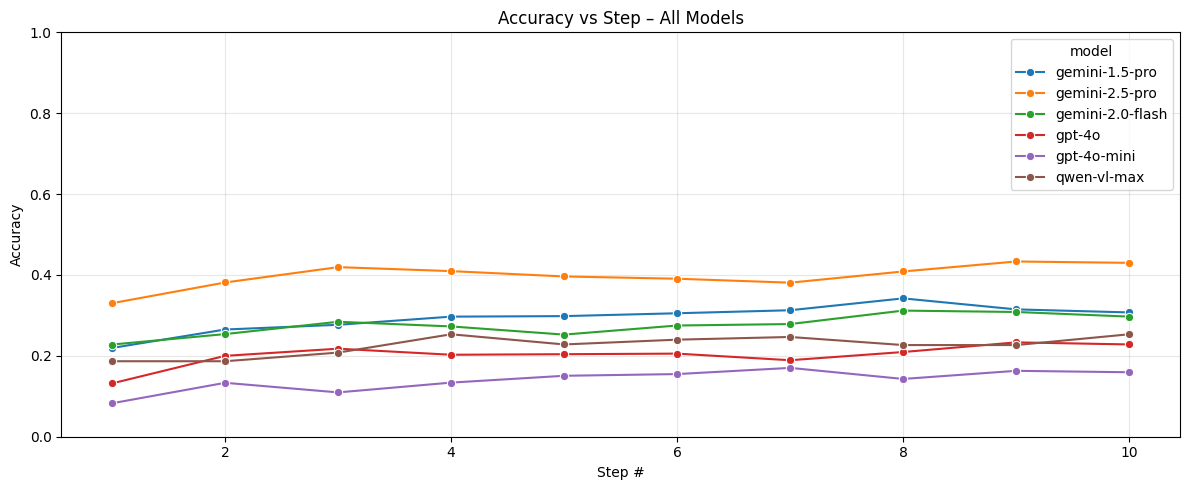

<Figure size 640x480 with 0 Axes>

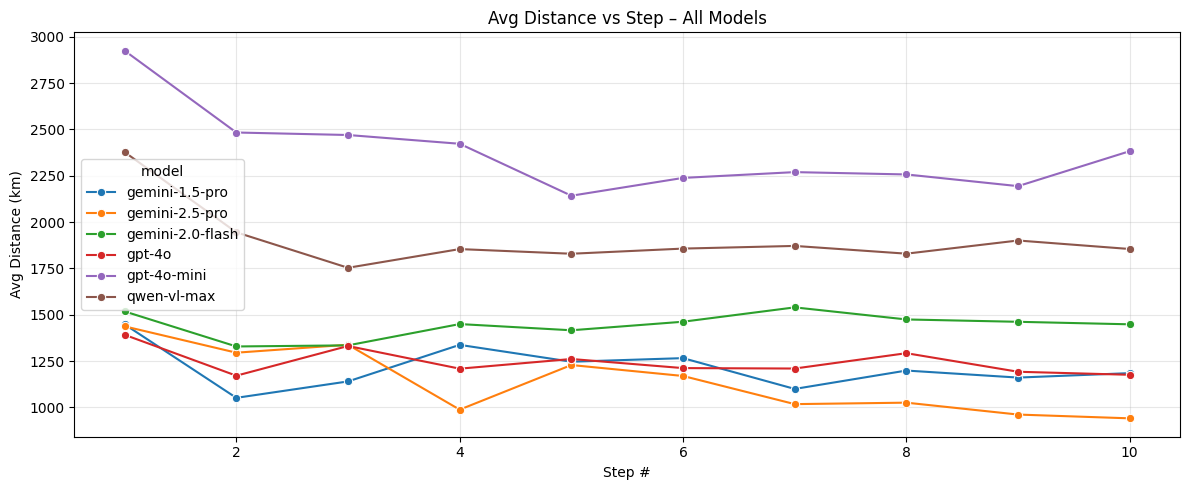

<Figure size 640x480 with 0 Axes>

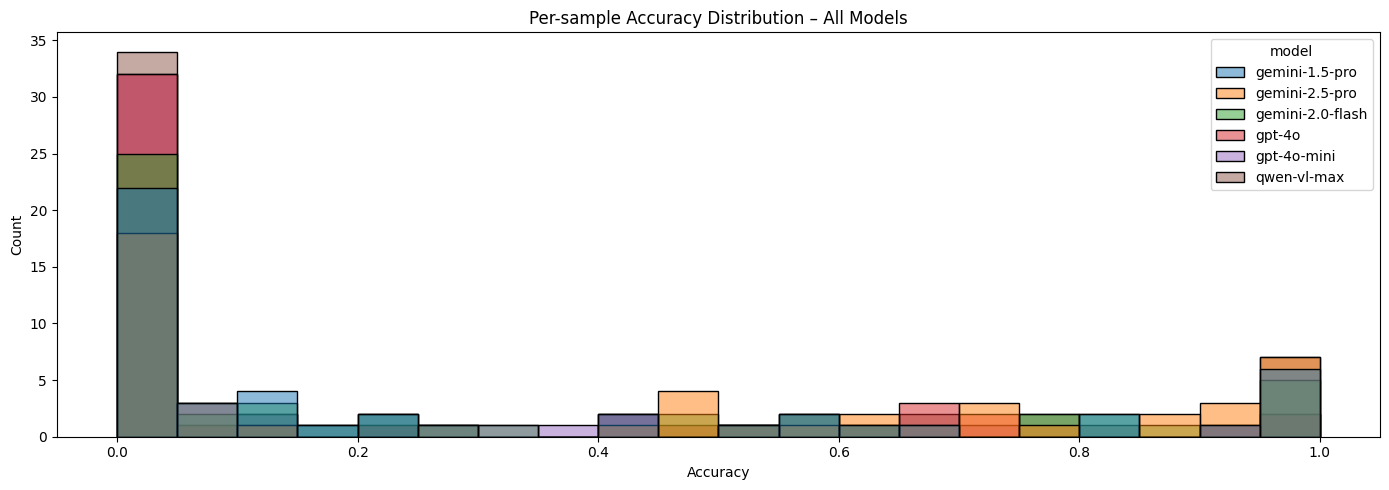

<Figure size 640x480 with 0 Axes>

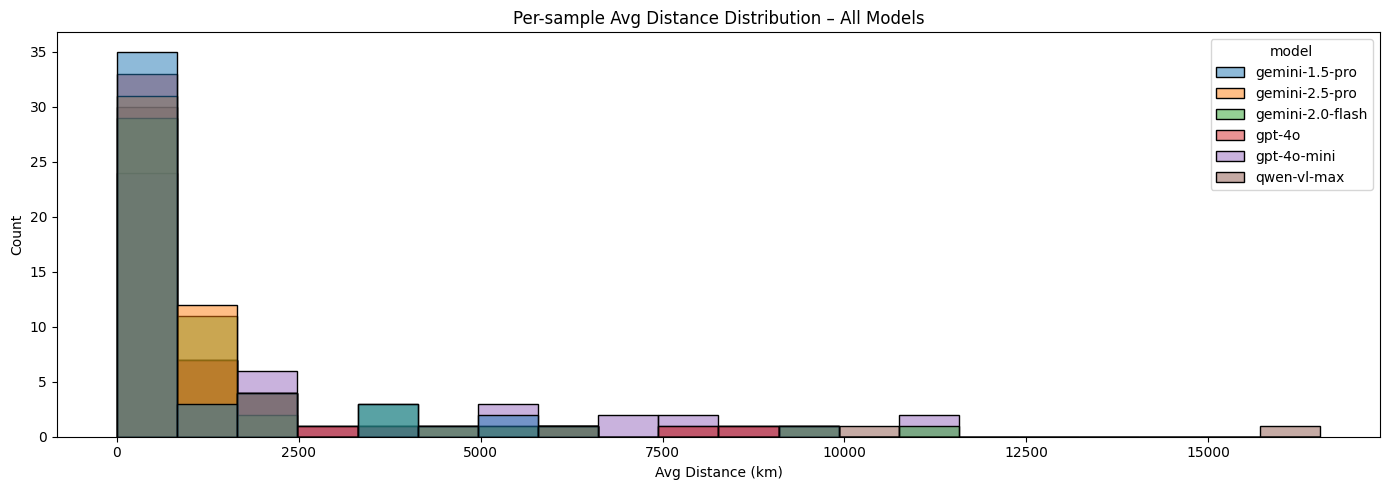

(                                sample_id  accuracy  avg_distance_km  \
 0    d6250b7f-4da5-42c1-8c8d-0423e67e77be  0.102041       199.328432   
 1    3bb51463-0a02-4ce4-9e61-6e0f28491897  0.000000      3975.258222   
 2    4acf7d7e-8309-4e57-88b2-1ea1019c1719  0.020619      4717.505061   
 3    c4d4352f-6285-42c1-bbae-231ca95da48a  0.000000      3344.098260   
 4    b4b889cf-008f-4b71-b901-bca7b3de3951  0.000000      1027.552253   
 ..                                    ...       ...              ...   
 295  574ac51d-1de1-46b2-9f90-5b1da1d79339  0.000000       211.256925   
 296  87e095f0-467b-4539-978b-46eecfdf1efc  0.000000      7975.326006   
 297  3badb1cb-5ffb-4c07-812e-ee85646a4279  0.766667        82.337977   
 298  1acb3834-1f22-4c0c-8cd3-b992e4546f88  0.000000      1374.658347   
 299  8dacb066-8fa4-4f03-87e3-34d86f5863fb  0.000000      3013.255468   
 
               model  
 0    gemini-1.5-pro  
 1    gemini-1.5-pro  
 2    gemini-1.5-pro  
 3    gemini-1.5-pro  
 4    g

<Figure size 640x480 with 0 Axes>

In [22]:
from benchmark import MapGuesserBenchmark
log_paths=["./results/test/20250809_010023/gemini-1.5-pro_log.json",
           "./results/test/20250809_010023/gemini-2.5-pro_log.json",
           "./results/test/20250810_212246/gemini-2.0-flash_log.json",
           "./results/test/20250811_143758/gpt-4o/gpt-4o_log.json",
           "./results/test/20250811_143758/gpt-4o-mini/gpt-4o-mini_log.json",
           "./results/test/20250811_143758/qwen-vl-max/qwen-vl-max_log.json",
           ]
save_path="/home/Omniscient/results/test/pictures/"
benchmark_helper = MapGuesserBenchmark(dataset_name="test")
plot_combined_results(log_paths,benchmark_helper,save_path,steps=10,show=True)

In [ ]:
import json
from benchmark import MapGuesserBenchmark
benchmark_helper = MapGuesserBenchmark(dataset_name="test")
golden_labels=benchmark_helper.load_golden_labels()
log_paths=["/home/Omniscient/results/test/20250809_010023/gemini-1.5-pro_log.json",
           "/home/Omniscient/results/test/20250809_010023/gemini-2.5-pro_log.json",
           ]
save_path="/home/Omniscient/results/test/20250809_010023/"
log_path=log_paths[1]
with open(log_path, "r") as f:
    logs = json.load(f)

# oberserving model performance on specific sample
model_name=log_path.split('/')[-1].split('_')[0]
for sample in golden_labels:
    step_res=step_analyze(logs,benchmark_helper,
                        save_path,model_name,20,
                        is_picture=True,
                        is_specific_sample=True,
                        sample_id=sample["id"],
                        save_picture=True,
                        picture_save_path=f"/home/Omniscient/results/test/sample_picture/{model_name}/{sample['id']}")

In [ ]:
import json
from pathlib import Path

base_dir   = Path("/home/Omniscient/results/test/20250809_010023")
files      = [
    base_dir / "gemini-1.5-pro" / "sample_analyze.json",
    base_dir / "gemini-2.5-pro" / "sample_analyze.json",
]

valid_ids_by_model = {}

# filter out the all-failed samples
for fp in files:
    with open(fp, "r", encoding="utf-8") as f:
        data = json.load(f)
    ids        = data["sample_id"]
    accuracies = data["accuracy"]

    valid_rows = [idx for idx, acc in accuracies.items() if acc and acc > 0]
    valid_ids  = [ids[idx] for idx in valid_rows]

    valid_ids_by_model[fp.parent.name] = valid_ids    

for model, ids in valid_ids_by_model.items():
    print(f"{model} has {len(ids)} valid samples:")
    print(ids)
    print("-" * 60)

gemini-1.5-pro has 39 valid samples:
['d6250b7f-4da5-42c1-8c8d-0423e67e77be', '3bb51463-0a02-4ce4-9e61-6e0f28491897', '7a606d59-46f3-4522-b2be-2e5a5576e155', '262d348a-a60a-42d8-bd4f-68aafe98d1fb', '1929ea7c-af27-42d0-9931-66d5ad451d21', '7bc2a39e-ac61-4704-a950-203117b4aca2', 'a77120f7-f65b-4ea4-8419-4c2f599c2ed8', 'bf12b96e-5ee7-4815-bc1e-2ef6ccaf3b5c', '6a5589de-e1fb-46c4-96c3-85cfb161444e', '3f0e8c12-109e-4db7-a228-52a156ca880d', 'a76f6ed2-5bb0-4750-bfd0-5a01fa052772', 'a6f20438-972f-48b0-8dc6-e95baec1c8c2', '4ee65f3b-aeaa-49d1-abda-28e270cca142', '3933f509-49f4-413f-b32d-95398910b3b6', 'e32c0681-97bc-440e-9d8e-c1cb9511d47d', '15861215-f932-426b-a6fa-08ae0cd5ae54', '011c76d0-d1cf-40f0-b243-3593448bce84', 'a16553c1-8b4a-44f0-9d6d-9c23b1b93c86', '0246f9d3-be8d-40f0-805e-d0446ef2d183', '54375156-8b78-4e60-afc9-f1172deba69d', '4fa45765-4ce7-4adc-a4fb-7f54149d6f27', '8ff247f4-efdf-47e8-8aab-7752f7a7a033', '41aa250b-f476-4c47-a8b3-1b170f892039', '6186abe6-6343-41bd-b7c6-ef65e5fb5a83', 'f

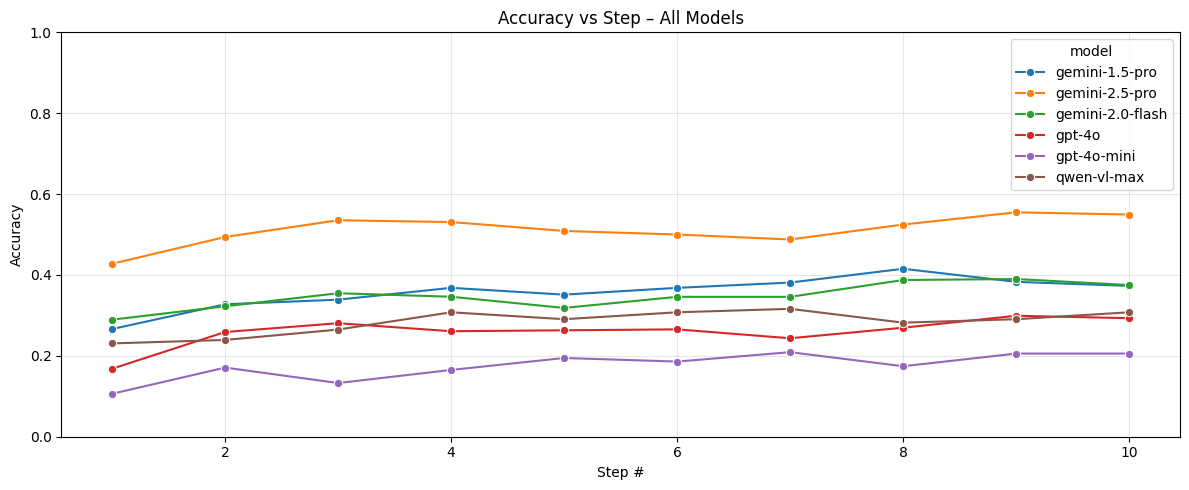

<Figure size 640x480 with 0 Axes>

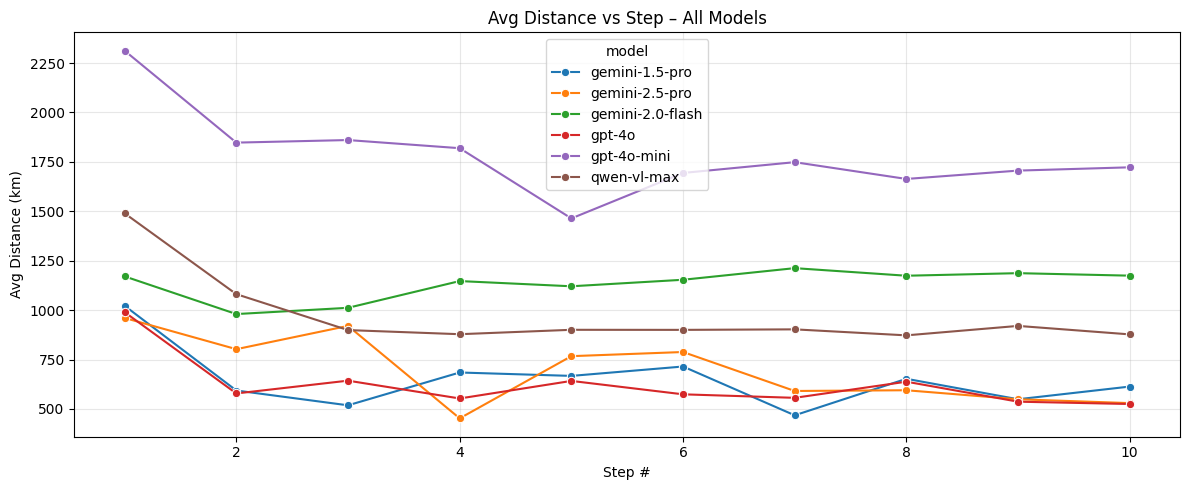

<Figure size 640x480 with 0 Axes>

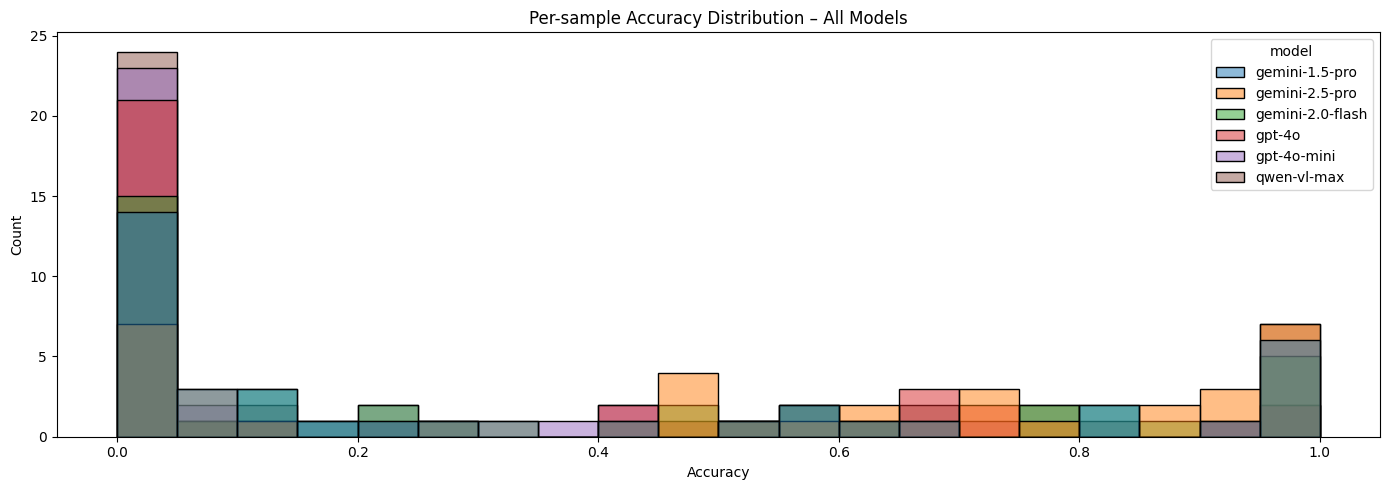

<Figure size 640x480 with 0 Axes>

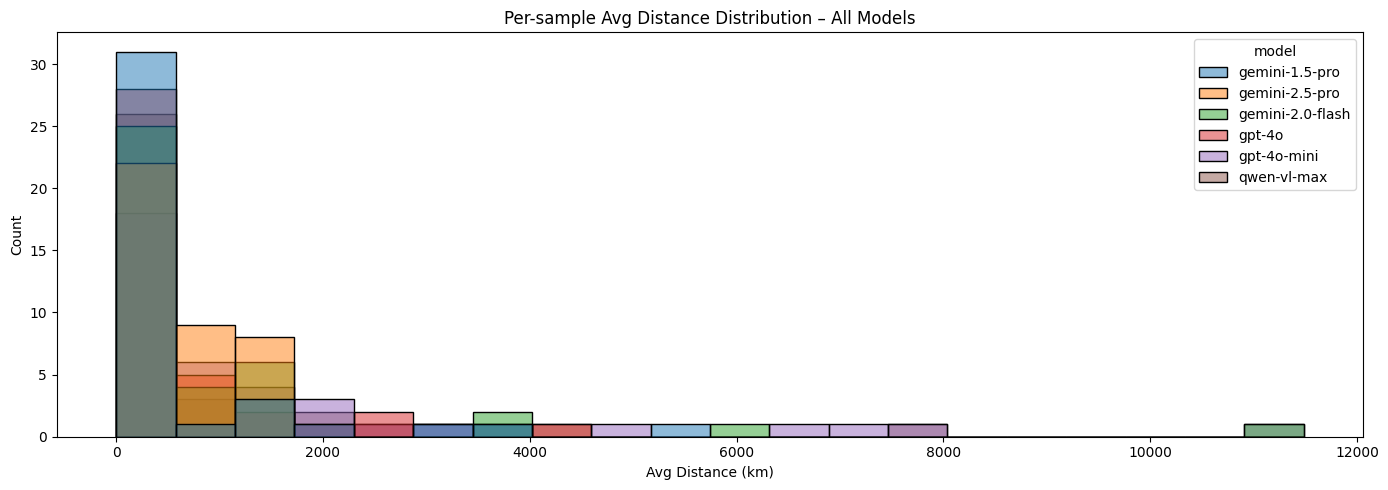

(                                sample_id  accuracy  avg_distance_km  \
 0    d6250b7f-4da5-42c1-8c8d-0423e67e77be  0.102041       199.328432   
 1    3bb51463-0a02-4ce4-9e61-6e0f28491897  0.000000      3975.258222   
 2    7a606d59-46f3-4522-b2be-2e5a5576e155  1.000000         3.093228   
 3    262d348a-a60a-42d8-bd4f-68aafe98d1fb  0.616162       112.056694   
 4    1929ea7c-af27-42d0-9931-66d5ad451d21  0.010204       480.020169   
 ..                                    ...       ...              ...   
 229  574ac51d-1de1-46b2-9f90-5b1da1d79339  0.000000       211.256925   
 230  87e095f0-467b-4539-978b-46eecfdf1efc  0.000000      7975.326006   
 231  3badb1cb-5ffb-4c07-812e-ee85646a4279  0.766667        82.337977   
 232  1acb3834-1f22-4c0c-8cd3-b992e4546f88  0.000000      1374.658347   
 233  8dacb066-8fa4-4f03-87e3-34d86f5863fb  0.000000      3013.255468   
 
               model  
 0    gemini-1.5-pro  
 1    gemini-1.5-pro  
 2    gemini-1.5-pro  
 3    gemini-1.5-pro  
 4    g

<Figure size 640x480 with 0 Axes>

In [27]:
filtered_ids=['d6250b7f-4da5-42c1-8c8d-0423e67e77be', '3bb51463-0a02-4ce4-9e61-6e0f28491897', '7a606d59-46f3-4522-b2be-2e5a5576e155', '262d348a-a60a-42d8-bd4f-68aafe98d1fb', '1929ea7c-af27-42d0-9931-66d5ad451d21', '7bc2a39e-ac61-4704-a950-203117b4aca2', 'a77120f7-f65b-4ea4-8419-4c2f599c2ed8', 'bf12b96e-5ee7-4815-bc1e-2ef6ccaf3b5c', '6a5589de-e1fb-46c4-96c3-85cfb161444e', '3f0e8c12-109e-4db7-a228-52a156ca880d', 'a76f6ed2-5bb0-4750-bfd0-5a01fa052772', 'a6f20438-972f-48b0-8dc6-e95baec1c8c2', '4ee65f3b-aeaa-49d1-abda-28e270cca142', '3933f509-49f4-413f-b32d-95398910b3b6', 'e32c0681-97bc-440e-9d8e-c1cb9511d47d', '15861215-f932-426b-a6fa-08ae0cd5ae54', '011c76d0-d1cf-40f0-b243-3593448bce84', 'a16553c1-8b4a-44f0-9d6d-9c23b1b93c86', '0246f9d3-be8d-40f0-805e-d0446ef2d183', '54375156-8b78-4e60-afc9-f1172deba69d', '4fa45765-4ce7-4adc-a4fb-7f54149d6f27', '8ff247f4-efdf-47e8-8aab-7752f7a7a033', '41aa250b-f476-4c47-a8b3-1b170f892039', '6186abe6-6343-41bd-b7c6-ef65e5fb5a83', 'f9d01601-da06-4286-b83f-aad48292ef56', '29521be4-0c47-40b4-9fe5-14dd37686eed', '0049770c-0e79-4f6e-a230-85815c5afca4', '108d3530-8cd1-4554-9e27-f4161c25b64f', '684589c2-db98-4fa0-a909-26677d622781', '9e52e1ef-b7c8-4290-a50c-dea42684329c', '54ccc34f-ae30-449b-83cf-3f6485186e38', '9903bb23-294e-44a2-9ecf-180808b82d67', '4381807b-d04c-4c04-8b93-78a588016cb7', 'c9d4d2c0-be12-4104-9fdf-3ffd7b9b539a', '574ac51d-1de1-46b2-9f90-5b1da1d79339', '87e095f0-467b-4539-978b-46eecfdf1efc', '3badb1cb-5ffb-4c07-812e-ee85646a4279', '1acb3834-1f22-4c0c-8cd3-b992e4546f88', '8dacb066-8fa4-4f03-87e3-34d86f5863fb']

plot_combined_results(
    log_paths,
    benchmark_helper,
    save_path="/home/Omniscient/results/test/filtered_pictures/",
    steps=10,
    sample_ids=filtered_ids, 
    show=True
)